In [1]:
import numpy as np 
import pylab as plt
import pandas as pd
%matplotlib inline

In [2]:
import matplotlib
params = {
        'axes.labelsize' : 16,
        'font.size' : 14,
        'legend.fontsize': 14,
        'xtick.labelsize': 16,
        'ytick.labelsize': 16,
        'text.usetex': False,
        'figure.figsize': [15, 10]
        }
matplotlib.rcParams.update(params)

In [3]:
# inputs
filename = '../sen_all_2.csv'
min_snr = 6
max_snr = 50
nbins_hist = 60
nbins_recall2d = 20

In [4]:
frbs_all = pd.read_csv(filename,  names=['id', 'mock', 'in_snr', 'det_snr', 'in_dm', 'det_dm', 'in_dt', 'det_dt', 
                                                  'in_l', 'det_l', 'in_m', 'det_m'], skiprows = 1)

In [5]:
frbs_all['in_dist'] = (frbs_all['in_l']**2 + frbs_all['in_m']**2)**(1/2)
frbs_all['det_dist'] = (frbs_all['det_l']**2 + frbs_all['det_m']**2)**(1/2)

frbs = frbs_all[(frbs_all['in_snr'] < max_snr) & (frbs_all['in_snr'] > min_snr)]

frb_missed_mask = frbs['det_snr'] == -1 
frb_no_map_mask = frbs['det_snr'] == -2

frb_no_map = frbs[frb_no_map_mask]
frb_missed = frbs[frb_missed_mask]

frb_detected = frbs[(~frb_missed_mask) & (~frb_no_map_mask)]

In [6]:
def ax_scatter(param, ax, fig, df):
    """
    Scatter plot of Recovered S/N vs Injected S/N with colorscale as FRB property/parameter
    """
    sc = ax.scatter(x=df['in_snr'], y=df['det_snr'], c=df['in_'+param], cmap='viridis', alpha=0.5)
    ax.set_ylabel('Recovered S/N')
    ax.grid()
    return sc

def ax_recall2d(param1, param2, nbins, frbs, frb_detected, ax):
    """
    Plots the 2D recall with respect to two input parameters. Also returns the 
    Area Under Curve (AUC) of this plot. 
    """
    H_in, xedges, yedges = np.histogram2d(frbs['in_'+param1], frbs['in_'+param2], bins=nbins)
    H_det, xedges, yedges = np.histogram2d(frb_detected['in_'+param1], frb_detected['in_'+param2], 
                                           bins = (xedges, yedges))
    hist_ratio = 100*H_det/H_in
    im = ax.imshow(hist_ratio, aspect='auto', interpolation='nearest', origin='low',
            extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]])
    ax.set_ylabel(param1.upper())
    AUC = np.nansum(hist_ratio)/(hist_ratio.shape[0]*hist_ratio.shape[1]*100)
    return AUC, im

def ax_hist(param, nbins, frbs, frb_detected, frb_missed, frb_no_map, ax):
    """
    plot histogram of distribution of a prameter for input, detected and missed FRBs  
    """
    in_range = frbs['in_'+param].max()-frbs['in_'+param].min()
    det_range = frb_detected['det_'+param].max()-frb_detected['det_'+param].min()
    if in_range > det_range:
        h, bins = np.histogram(frbs['in_'+param], bins=nbins)
    else:
        h, bins = np.histogram(frb_detected['det_'+param], bins=nbins)
    frbs.hist('in_'+param, alpha=0.5, bins = bins,label='Injected', ax=ax)
    frb_detected.hist('det_'+param, ax=ax, alpha=0.5, bins=bins, label='Detected')
    frb_missed.hist('in_'+param, ax=ax, label='Missed',alpha=0.5, bins=bins)
    frb_no_map.hist('in_'+param, ax=ax, label='Mock not found',alpha=0.5, bins=bins)
    ax.set_xlabel(param.upper())
    ax.set_title('')
    ax.legend()

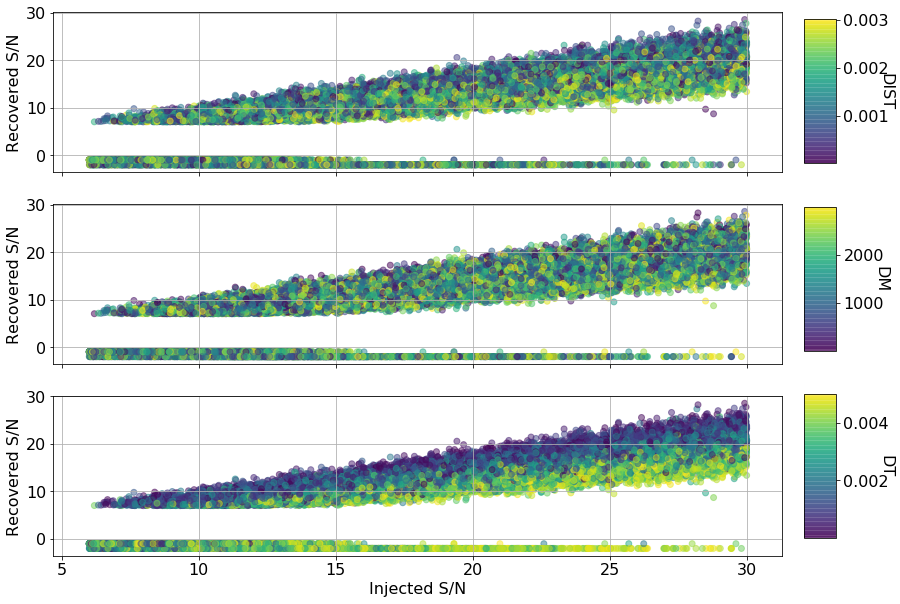

In [8]:
sc = []
label = ['DIST', 'DM', 'DT']
fig, ax = plt.subplots(3,1, sharex=True)
sc.append(ax_scatter('dist', ax=ax[0], fig=fig, df=frbs))
sc.append(ax_scatter('dm', ax=ax[1], fig=fig, df=frbs))
sc.append(ax_scatter('dt', ax=ax[2], fig=fig, df=frbs))
ax[2].set_xlabel('Injected S/N')
fig.subplots_adjust(right=0.8)

for i in range(3):
    cbar_ax = fig.add_axes([0.82, 0.15+(2-i)*(0.6/3+0.06), 0.03, 0.6/3])
    cbar = fig.colorbar(sc[i], cax=cbar_ax)
    cbar.set_label(label[i], rotation=270)

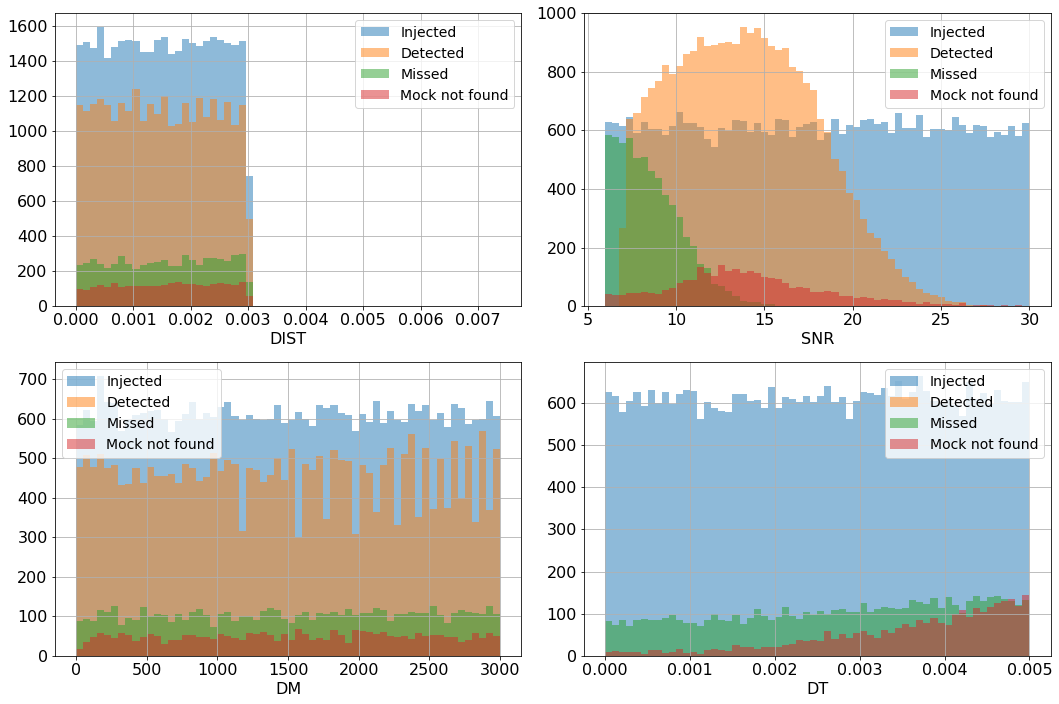

In [9]:
fig, ax = plt.subplots(2,2)
ax_hist('dist', nbins_hist, frbs, frb_detected, frb_missed, frb_no_map, ax=ax[0,0])
ax_hist('snr', nbins_hist, frbs, frb_detected, frb_missed, frb_no_map, ax=ax[0,1])
ax_hist('dm', nbins_hist, frbs, frb_detected, frb_missed, frb_no_map, ax=ax[1,0])
ax_hist('dt', nbins_hist, frbs, frb_detected, frb_missed, frb_no_map, ax=ax[1,1])
plt.tight_layout()

Text(0.5, 0, 'SNR')

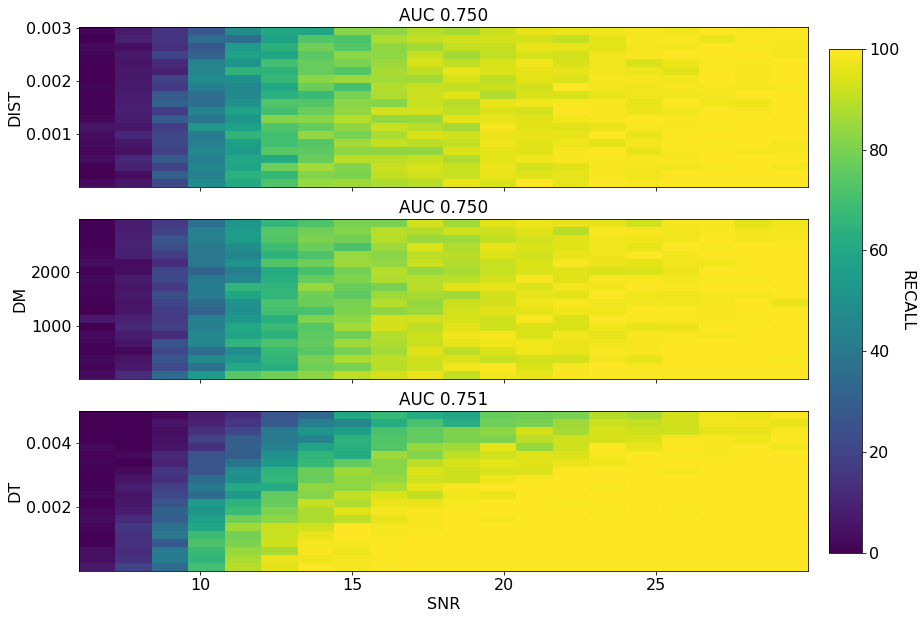

In [10]:
fig, ax = plt.subplots(3,1, sharex=True)
AUC_dist_snr, im0 = ax_recall2d('dist', 'snr', nbins_recall2d, frbs, frb_detected, ax=ax[0])
ax[0].set_title(f'AUC {AUC_dist_snr:0.3f}')

AUC_dm_snr, im1 = ax_recall2d('dm', 'snr', nbins_recall2d, frbs, frb_detected, ax=ax[1])
ax[1].set_title(f'AUC {AUC_dm_snr:0.3f}')

AUC_dt_snr, im1 = ax_recall2d('dt', 'snr', nbins_recall2d, frbs, frb_detected, ax=ax[2])
ax[2].set_title(f'AUC {AUC_dt_snr:0.3f}')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.03, 0.7])
cbar = fig.colorbar(im0, cax=cbar_ax)
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label('RECALL', rotation=270)
ax[2].set_xlabel('SNR')